# 🔍 Cracking a Ransomware Case with ChatGPT-3.5
This notebook uses your OpenAI API key to analyze a synthetic forensic log related to a ransomware case.

In [21]:
!pip install openai
!pip install python-dotenv
!pip install dspy-ai==2.4.17
!pip install graphviz


import json
import networkx as nx
import matplotlib.pyplot as plt
import openai


## Step 1: Set Your OpenAI API Key

In [6]:
# Upload both the API key and the forensic JSON file
from google.colab import files
uploaded = files.upload()


Saving openai_api_key.txt to openai_api_key (2).txt


In [7]:
from google.colab import files
uploaded = files.upload()

Saving synthetic_forensic_log.json to synthetic_forensic_log (2).json


## 📂 Step 2: Load Forensic Log

In [22]:

# Load OpenAI API key
with open('openai_api_key.txt') as f:
    openai.api_key = f.read().strip()

# Load and sanitize the synthetic forensic log
with open('synthetic_forensic_log.json', 'r') as f:
    forensic_log = json.load(f)

# Sanitize sensitive fields
for key in forensic_log:
    for entry in forensic_log[key]:
        if 'url' in entry:
            entry['url'] = '[REDACTED URL]'
        if 'command' in entry:
            entry['command'] = '[REDACTED PowerShell Command]'
        if 'path' in entry and 'invoice_tool.exe' in entry['path']:
            entry['path'] = entry['path'].replace('invoice_tool.exe', '[REDACTED FILE]')

# Print the cleaned log
for key in forensic_log:
    print(f'[{key}]')
    for item in forensic_log[key]:
        print(item)
    print('\n')

# Save the sanitized output to be used in graph visualization
with open('output1.json', 'w') as f:
    json.dump(forensic_log, f, indent=2)

print(" Cleaned log saved as output1.json")


[browser_history]
{'timestamp': '2024-11-02T03:12:00', 'url': '[REDACTED URL]', 'action': 'download'}


[powershell_logs]
{'timestamp': '2024-11-02T03:14:00', 'command': '[REDACTED PowerShell Command]'}


[filesystem_changes]
{'timestamp': '2024-11-02T03:16:00', 'path': '/finance', 'action': 'encrypt'}
{'timestamp': '2024-11-02T03:43:00', 'path': '/desktop/ransom_note.txt', 'action': 'create'}


[registry_changes]
{'timestamp': '2024-11-02T03:20:00', 'key': 'HKCU\\Software\\Microsoft\\Windows\\CurrentVersion\\Run', 'value': 'invoice_tool.exe'}


[system_events]
{'timestamp': '2024-11-02T03:45:00', 'event': 'reboot'}


 Cleaned log saved as output1.json


##  Step 3: Generate Natural Language Summary with ChatGPT-3.5

In [23]:
remediation_prompt = f"""
You are a digital forensics assistant helping investigate a ransomware case using synthetic log data (educational purpose only).

Based on the logs below, perform the following tasks:

1. Identify how the ransomware was introduced into the system.
2. List all suspicious or contaminated artifacts (files, registry keys, commands, etc.).
3. Recommend step-by-step remediation and response actions.

Only include these three sections in your response:
- Infection Vector
- Contaminated Artifacts
- Remediation Plan

Logs:
{forensic_context}
"""

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are a helpful cybersecurity incident response expert."},
        {"role": "user", "content": remediation_prompt}
    ],
    temperature=0.2,
    max_tokens=800
)

print(" Full LLM-Based Ransomware Response Plan\n")
print(response.choices[0].message.content)


 Full LLM-Based Ransomware Response Plan

**Infection Vector:**
Based on the provided logs, the ransomware was introduced into the system through a malicious download initiated from the browser history followed by execution of a PowerShell command.

**Contaminated Artifacts:**
1. **Filesystem Changes:**
   - Encryption of the "/finance" directory.
   - Creation of the ransom note file "/desktop/ransom_note.txt".

2. **Registry Changes:**
   - Addition of a registry key to run "invoice_tool.exe" on system startup.

**Remediation Plan:**
1. **Isolate the Infected System:**
   - Immediately disconnect the infected system from the network to prevent further spread of the ransomware.

2. **Identify and Quarantine Malicious Artifacts:**
   - Locate and quarantine the encrypted files in the "/finance" directory and the ransom note file "/desktop/ransom_note.txt".
   - Remove the registry key associated with running "invoice_tool.exe" on startup.

3. **Restore from Backup:**
   - If possible, 

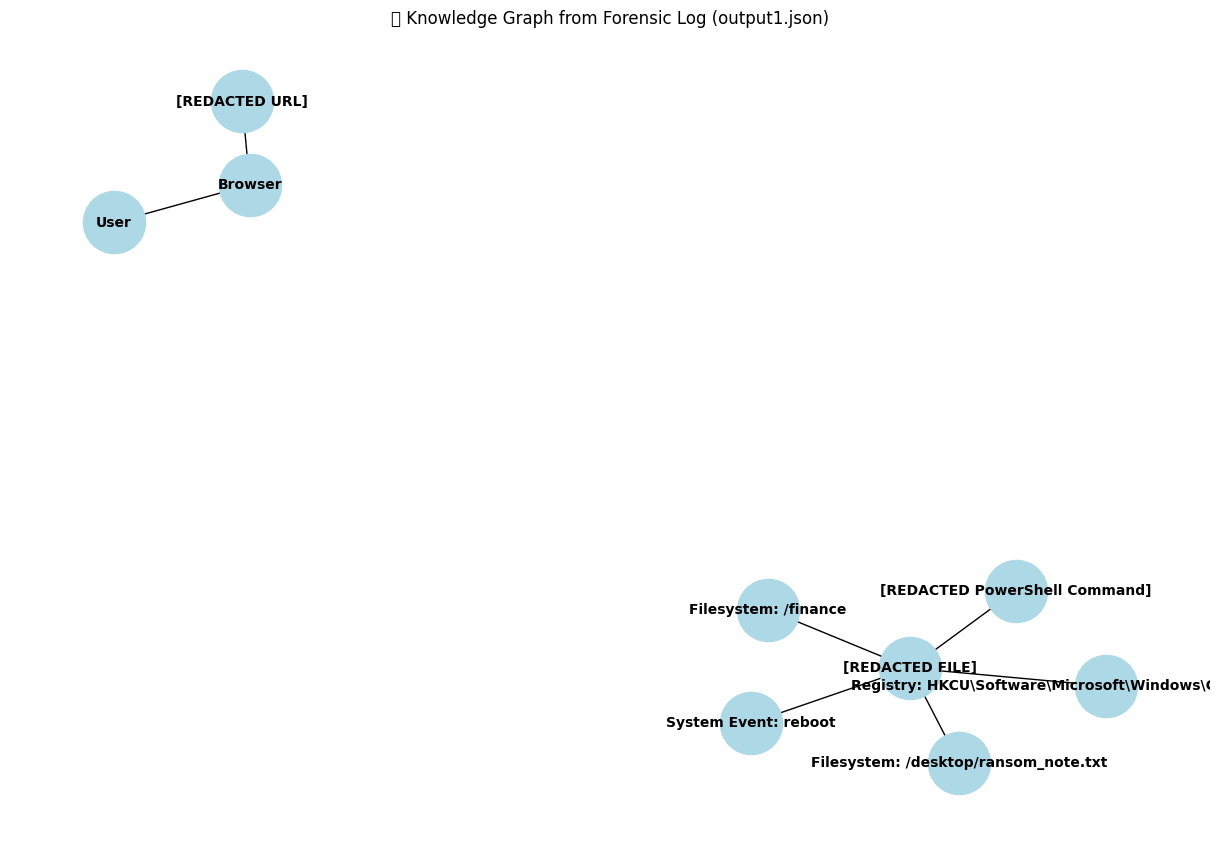

In [19]:


# Load the cleaned forensic log
with open('output1.json', 'r') as f:
    log = json.load(f)

# Create the graph
G = nx.Graph()

# Extract relevant nodes and edges
for entry in log.get('browser_history', []):
    G.add_edge("User", "Browser")
    G.add_edge("Browser", entry.get('url', '[REDACTED URL]'))

for entry in log.get('powershell_logs', []):
    G.add_edge("[REDACTED FILE]", entry.get('command', '[REDACTED PowerShell Command]'))

for entry in log.get('filesystem_changes', []):
    path = entry.get('path', '[UNKNOWN PATH]')
    G.add_edge("[REDACTED FILE]", f"Filesystem: {path}")

for entry in log.get('registry_changes', []):
    reg_key = entry.get('key', '[UNKNOWN KEY]')
    G.add_edge("[REDACTED FILE]", f"Registry: {reg_key}")

for entry in log.get('system_events', []):
    event = entry.get('event', '[UNKNOWN EVENT]')
    G.add_edge("[REDACTED FILE]", f"System Event: {event}")

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    with_labels=True,
    node_color='lightblue',
    node_size=2000,
    font_size=10,
    font_weight='bold'
)
plt.title("📊 Knowledge Graph from Forensic Log (output1.json)")
plt.show()
